In [17]:
#Create Dataframe

import pandas as pd
df = pd.read_excel("~/Desktop/Research/LMU_Wellness/data/Wellness_Database_May19.xlsx", sheet_name="Wellness Responses")

sore_areas = ["Neck", "Back", "Shoulders", "Chest", "Arms", "Hip Flexors", "Glutes", "Hamstrings", "Quadricps", "Adductors", "Calves", "Feet"]
for area in sore_areas:
    df[area] = df["Select where you are sore:"].str.contains(area, na=False).astype(int)

# Drop the original "Select where you are sore:" column
df = df.drop("Select where you are sore:", axis=1)

df['No Injury'] = (df['What is your injury status?'] == 'Full = I have no injury').astype(int)
df['Some Injury'] = (df['What is your injury status?'] == 'Limited = I need a modification during lift / practice').astype(int)
df['Injury'] = (df['What is your injury status?'] == 'Out = I have an injury').astype(int)

columns_to_drop = ['How stressed are you?', 'How many hours did you sleep?', 'How well did you hydrate?', 'Shoulders', 'Arms', 'Hip Flexors', 'Hamstrings', 'Quadricps', 'Adductors',
       'Calves', 'Feet', 'Some Injury', 'Injury','Timestamp', 'Athlete ID #', 'Data ID', 'Week ID', 'Week ID Refined', 'Date Value', 'Year ID', 'Season ID', 'Injury Refined', 'Position', 'Classification', 'Stress RA', 'Stress StdDev', 'Stress Z-Score', 'Stress Wellness Score', 'Sleep Quality RA', 'Sleep Quality StdDev', 'Sleep Quality Z-Score', 'Sleep Quality Wellness Score', 'Sleep Quantity RA', 'Sleep Quantity StdDev', 'Sleep Quantity Z-Score', 'Sleep Quantity Wellness Score', 'Soreness RA', 'Soreness StdDev', 'Soreness Z-Score', 'Soreness Wellness Score', 'Hydrate RA', 'Hydrate StdDev', 'Hydrate Z-Score', 'Hydrate Wellness Score', 'Fuel RA', 'Fuel StdDev', 'Fuel Z-Score', 'Fuel Wellness Score', 'Readiness Score']
df = df.drop(columns_to_drop, axis=1)

# Drop the original column
df = df.drop('What is your injury status?', axis=1)

df = df.dropna(subset=["How well did you fuel?"])
df = df.rename(columns={"Athlete Name": "AthleteName"})

In [19]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

# Prepare the data
X = df.drop(["What is your readiness score? ", "AthleteName"], axis=1)  # Features
y = df["What is your readiness score? "]  # Target variable

# Add a constant term to the features
X = sm.add_constant(X)

# Fit the ordinary least squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Compute leverage values
leverage = OLSInfluence(results).hat_matrix_diag

# Compute Cook's distance
cooks_d = OLSInfluence(results).cooks_distance[0]

# Set a threshold for identifying influential points
threshold = 4 / len(X)  # You can adjust the threshold as needed

# Identify influential points based on Cook's distance and leverage
influential_points = np.where((cooks_d > threshold) | (leverage > np.mean(leverage) + 2 * np.std(leverage)))

# Remove values
for i in range(len(influential_points[0])):
    df = df.drop(index = (influential_points[0][i]+1061) ) 

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

mse = []

for i in range(1071, 1545):
    train_df = df.truncate(after=i)
    
    X = train_df.drop(["What is your readiness score? "], axis=1)  # Features (excluding target variable)
    y = train_df["What is your readiness score? "]  # Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    mse.append(rmse)

In [33]:
mse

[24.93279355144092,
 47.79594781999675,
 38.37551606685473,
 41.772322230490126,
 41.979663396974736,
 92.6560461221162,
 55.47949453594557,
 102.94309511351538,
 64.38722003828588,
 49.92086856038121,
 47.40641086064183,
 44.9428000078638,
 61.580504505337785,
 48.910396469289374,
 46.655840237321996,
 56.57739050340288,
 41.63389974487591,
 38.03889066027226,
 41.26507695912919,
 41.62669915087083,
 40.117376968260366,
 41.004707146741424,
 44.16000736799169,
 43.11895514560615,
 41.6720888090232,
 22.05700048547971,
 24.30279716461921,
 18.151508525085525,
 17.637788763154994,
 33.35182047633949,
 30.37451908241971,
 27.722437715294088,
 31.83804790273867,
 29.194340683100418,
 32.313627550475054,
 30.960357195785523,
 17.978809832763137,
 19.535840355268217,
 15.137792885110123,
 15.730836249651375,
 19.443787520986938,
 17.253065700694247,
 16.957705058725047,
 18.22864768948003,
 18.093755658382094,
 17.595240450464765,
 21.657581945060073,
 17.878070031501718,
 16.83836499023276

<function matplotlib.pyplot.show(close=None, block=None)>

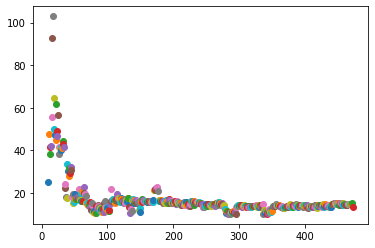

In [34]:
import matplotlib.pyplot as plt

for i in range(10,474):
    plt.scatter(i,mse[i-10])

plt.show

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

score_list = []

nonfeatures = set(df.columns) - set(['How stressed are you?', 'How well did you sleep?', 'How many hours did you sleep?', 'How sore are you?', 'How well did you fuel?', 'Back', 'Shoulders', 'Chest', 'Hip Flexors', 'Glutes', 'Hamstrings', 'Quadricps', 'Calves', 'Feet', 'No Injury'])
nonfeatures = list(nonfeatures)

for i in range(1071, 1545):
    train_df = df.truncate(after=i)
    
    X = train_df.drop(nonfeatures, axis=1)  # Features (excluding target variable)
    y = train_df["What is your readiness score? "]  # Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    
    score_list.append(score)

In [46]:
score_list

[-28.619419478737573,
 -28.619419478737573,
 -111.66287532387948,
 -50.78499999999967,
 0.4865482769226612,
 0.4865482769226612,
 -1.1128548034934433,
 -0.2173869777714843,
 -2.235271859345567,
 -1.1568909465580206,
 -1.1859446161625042,
 0.14848418196670166,
 -1.3425330574418686,
 -1.3425330574418686,
 -0.43789333175968004,
 -0.5714702791466033,
 -3.4952290680219322,
 -2.459752206346495,
 -1.3287591081186605,
 -1.692465774278813,
 -0.761562668939255,
 -1.3780304560581622,
 -0.26709430672850853,
 -0.6844028600093353,
 -0.18026359212885246,
 -0.4213382755122581,
 -3.3606738449412834,
 -4.666475925177666,
 0.1441867099860168,
 -0.29010902249807446,
 -0.03354842980749839,
 -0.03354842980749839,
 -0.3804827240360167,
 0.24870930076173803,
 -0.4461011285649039,
 0.47428643691244277,
 0.46596838155507325,
 0.2824210386584721,
 0.3844052812910058,
 0.357986101890966,
 0.796935180651564,
 0.7596980950085377,
 0.2763650926003869,
 -0.035413226632536876,
 0.562145136514672,
 0.5099658470132562,


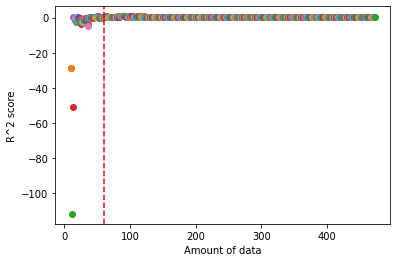

In [47]:
import matplotlib.pyplot as plt

for i in range(10, 474):
    if i == 15:
        continue
    plt.scatter(i, score_list[i-10])

plt.axvline(x=60, color='r', linestyle='--')  # Vertical line at x = 60

plt.xlabel('Amount of data')
plt.ylabel('R^2 score')

plt.show()


In [37]:
df_park = df[df.AthleteName == 'Kailey Park']
df_park = df_park.drop("AthleteName", axis=1)

features_to_drop = list(set(df_park.columns) - set(['How stressed are you?', 'How well did you hydrate?', 'How well did you fuel?', 'Back', 'Hip Flexors', 'Hamstrings', 'Quadricps', 'Adductors', 'Calves']))
X = df_park.drop(features_to_drop, axis=1)  # Features (excluding target variable)
y = df_park["What is your readiness score? "]  # Target variable

indices = list(df_park.index.values)
del indices[:4]

score_list = []

for i in indices:
    train_df = df_park.truncate(after=i)
    
    X = train_df.drop(features_to_drop, axis=1)  # Features (excluding target variable)
    y = train_df["What is your readiness score? "]  # Target variable
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    
    score_list.append(score)
    

/Users/gbutts/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


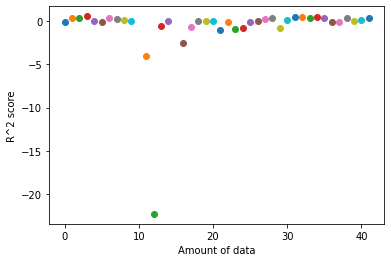

In [41]:
import matplotlib.pyplot as plt

for i in range(len(indices)):
    if i == 15:
        continue
    plt.scatter(i, score_list[i-10])

#plt.axvline(x=60, color='r', linestyle='--')  # Vertical line at x = 60

plt.xlabel('Amount of data')
plt.ylabel('R^2 score')

plt.show()